In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys

sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain,DetBenchEval
from effdet.efficientdet import HeadNet
from ensemble_boxes import *
from torch.utils.data import Dataset, DataLoader
import gc
import re


In [3]:
class BaseWheatTTA:
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)
def process_det(index, det, score_threshold=0.25):
    boxes = det[index].detach().cpu().numpy()[:,:4]    
    scores = det[index].detach().cpu().numpy()[:,4]
    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
    boxes = (boxes).clip(min=0, max=511).astype(int)
    indexes = np.where(scores>score_threshold)
    boxes = boxes[indexes]
    scores = scores[indexes]
    return boxes, scores

from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [4]:
def make_tta_predictions(images, score_threshold=0.1,model = None):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = model(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [5]:
Round_N = 1
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 4
    n_epochs = 10
    lr = 0.0002

    folder = 'pseudo'

    verbose = True
    verbose_step = 1

    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )


# Adjusted Train code 

In [6]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2,
                                     val_shift_limit=0.2, p=0.9), 
                A.RandomBrightnessContrast(brightness_limit=0.2,  
                                           contrast_limit=0.2, p=0.9),
            ], p=0.9),
            A.ToGray(p=0.1),  
            A.HorizontalFlip(p=0.5), 
            A.VerticalFlip(p=0.5),  
            A.Resize(height=512, width=512, p=1),  
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),  
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(  
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )




class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

import warnings

warnings.filterwarnings("ignore")


class Fitter:

    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                print("better model find at epoch:{}".format(self.epoch))
                best_weight=self.model.model.state_dict()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
        return best_weight

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()

            loss, _, _ = self.model(images, boxes, labels)

            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')





def collate_fn(batch):
    return tuple(zip(*batch))


def run_training(train_dataset,validation_dataset,train_net=None):
    device = torch.device('cuda:0')
    train_net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=train_net, device=device, config=TrainGlobalConfig)
    best_weight = fitter.fit(train_loader, val_loader)
    return best_weight

# Adjusted Dataset for train/test data

In [7]:
import torch
import random
import cv2
import numpy as np
from torch.utils.data import Dataset

TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'
TEST_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:, [0, 1, 2, 3]] = target['boxes'][:, [1, 0, 3, 2]]  # yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        if self.marking[self.marking['image_id'] == image_id]['source'].all() == 'BULLBULL':
            image = cv2.imread(f'{TEST_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        else:
            image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] 
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):

        w, h = imsize, imsize 
        s = imsize // 2

        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]  

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32) 
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)  
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc 
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw  
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[
            np.where((result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1]) > 0)]
        return result_image, result_boxes

# Predict function

In [8]:
def get_valid_transforms():
    return A.Compose([
        A.Resize(height=512, width=512, p=1.0),
        ToTensorV2(p=1.0),
    ], p=1.0)

DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever_test(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

dataset = DatasetRetriever_test(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)


def collate_fn(batch):
    return tuple(zip(*batch))


def get_valnet_file(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d6')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()


def make_predictions(images=None, score_threshold=0.1, model=None):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = model(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]
                  

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes'] / (image_size - 1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr,
                                                  skip_box_thr=skip_box_thr)
    boxes = boxes * (image_size - 1)
    return boxes, scores, labels

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

# Predict label for test set

In [9]:
def predict_test(data_loader,net):
    results = []
    testdf_psuedo = []

    for images, image_ids in data_loader:
        predictions = make_predictions(images=images,model=net)
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            for box in boxes:
                result = {
                    'image_id': image_id,
                    'source': 'BULLBULL',
                    'width':1024,
                    'height':1024,
                    'x': box[0],
                    'y': box[1],
                    'w': box[2],
                    'h': box[3]        
                }
                testdf_psuedo.append(result)

    test_df_pseudo = pd.DataFrame(testdf_psuedo, columns=['image_id', 'width', 'height', 'source', 'x', 'y', 'w', 'h'])
    return test_df_pseudo

In [10]:
def generate_train(test_df_pseudo):
    train_df = pd.read_csv('../input/global-wheat-detection/train.csv')

    bboxs = np.stack(train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
    for i, column in enumerate(['x', 'y', 'w', 'h']):
        train_df[column] = bboxs[:, i]
    train_df.drop(columns=['bbox'], inplace=True)
    frames = [train_df, test_df_pseudo]
    train_df = pd.concat(frames)
    
    return train_df

In [11]:
def split_train_val(train_df):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    df_folds = train_df[['image_id']].copy()
    df_folds.loc[:, 'bbox_count'] = 1
    df_folds = df_folds.groupby('image_id').count()
    df_folds.loc[:, 'source'] = train_df[['image_id', 'source']].groupby('image_id').min()['source']
    df_folds.loc[:, 'stratify_group'] = np.char.add(
        df_folds['source'].values.astype(str),
        df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
    )
    df_folds.loc[:, 'fold'] = 0

    for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
        df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number


    train_dataset = DatasetRetriever(
        image_ids=train_df.image_id.unique(),
        marking=train_df,
        transforms=get_train_transforms(),
        test=False,
    )

    validation_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
        marking=train_df,
        transforms=get_valid_transforms(),
        test=True,
    )
    return train_dataset,validation_dataset

In [12]:
def get_train_net(eval_net):
    config = get_efficientdet_config('tf_efficientdet_d6')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    # checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(eval_net.model.state_dict())

    # del checkpoint
    gc.collect()

    net = DetBenchTrain(net, config)
    net = net.train()
    return net.cuda()

def get_test_net(best_weigth):
    config = get_efficientdet_config('tf_efficientdet_d6')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    # checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(best_weigth)

    # del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net = net.train()
    return net.cuda()

In [13]:
test_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

test_net = get_valnet_file('../input/efficientdet6-8-12-10-mix/effdet6-cutmix-augmix/last-checkpoint.bin')

# N round Pseudo labeling

In [14]:
if len(os.listdir('../input/global-wheat-detection/test/'))<11:
     pass
else:
    for i in range(Round_N):
        train_net = get_train_net(test_net)
        test_df_pseudo = predict_test(data_loader=test_loader,net=test_net)
        train_df = generate_train(test_df_pseudo)
        train_dataset,validation_dataset = split_train_val(train_df)
        best_weight = run_training(train_dataset=train_dataset,validation_dataset=validation_dataset,train_net=train_net)
        new_test_net = get_test_net(best_weight)
        test_net = new_test_net

In [15]:
import ensemble_boxes

if len(os.listdir('../input/global-wheat-detection/test/'))<11:
    results = []

    for images, image_ids in test_loader:
        predictions = make_tta_predictions(images,model=test_net)
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = (boxes * 2).astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
            results.append(result)

    test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
    test_df.to_csv('submission.csv', index=False)
    

else:
    results = []
    new_test_net = get_valnet_file('pseudo/last-checkpoint.bin')
    for images, image_ids in test_loader:
        predictions = make_tta_predictions(images,model=new_test_net)
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = (boxes * 2).astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
            results.append(result)

    test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
    test_df.to_csv('submission.csv', index=False)
    


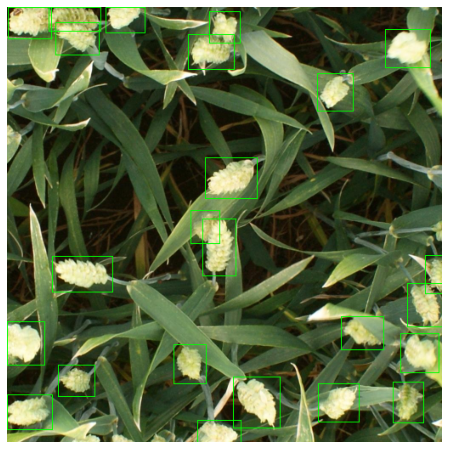

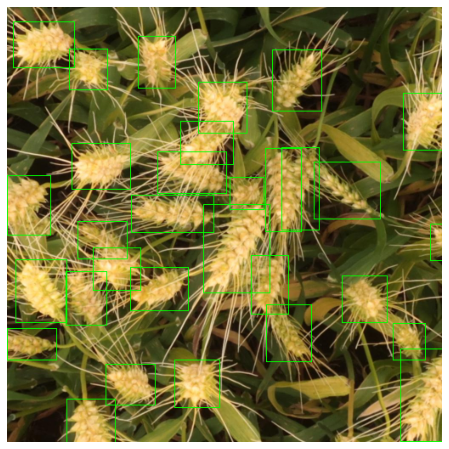

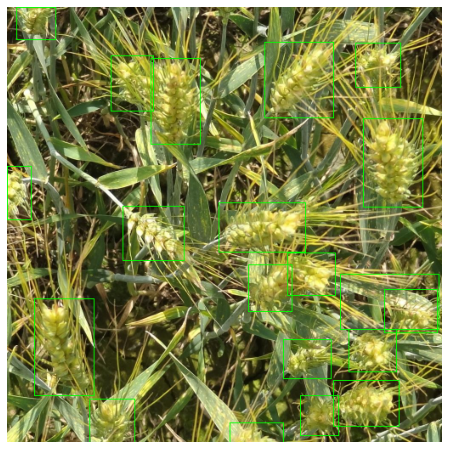

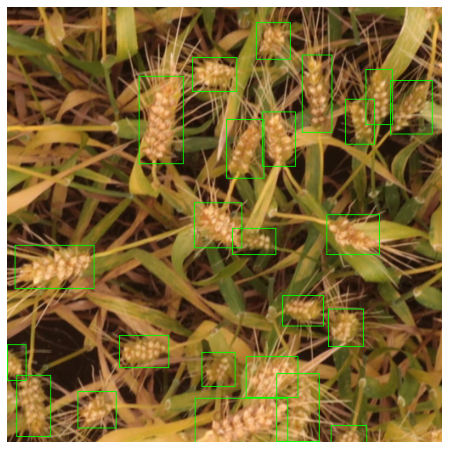

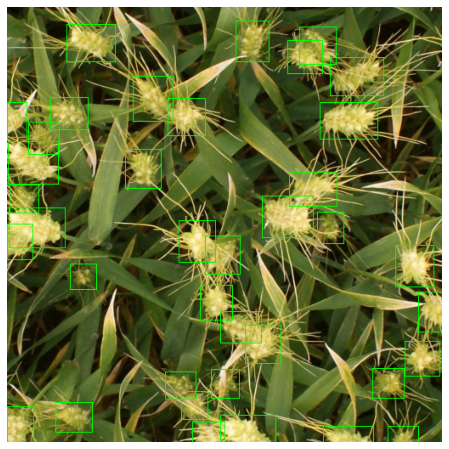

In [16]:
for j, (images, image_ids) in enumerate(test_loader):
    if j>9:
        break
    else:
        predictions = make_tta_predictions(images,model=test_net)
        i = 1
        sample = images[i].permute(1,2,0).cpu().numpy()
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.round().astype(np.int32).clip(min=0, max=1023)

        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        for box in boxes:
                 cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 1, 0), 1)

        ax.set_axis_off()
        ax.imshow(sample)
        

In [17]:
pd.read_csv('/kaggle/working/submission.csv').head(5)

,image_id,PredictionString
0,796707dd7,0.9454 710 821 110 104 0.9330 503 784 97 104 0...
1,2fd875eaa,0.9607 466 353 122 96 0.9434 392 793 76 92 0.9...
2,cc3532ff6,0.9768 769 827 166 165 0.9585 911 124 111 95 0...
3,53f253011,0.9627 13 34 145 108 0.9527 623 100 117 144 0....
4,f5a1f0358,0.9544 943 430 80 190 0.9417 688 203 112 93 0....
